In [ ]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')    
%matplotlib inline 

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from scipy.linalg import svd

import warnings
warnings.filterwarnings('ignore')

## Загрузка и объединение датасетов

In [ ]:
df = pd.read_csv('https://github.com/nkozemaslova/Data_2022/releases/download/data3/SpotifyFeatures.csv')
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [ ]:
df2 = pd.read_csv('https://github.com/nkozemaslova/Data_2022/releases/download/data4/spotify_dataset.csv', 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')

In [ ]:
# Переименовали колонку "artistname" во втором датасете на "artist_name"
df2 = df2.rename(columns={'artistname': 'artist_name'})

# Переименовали колнку "trackname" во втором датасете на "track_name"
df2 = df2.rename(columns={'trackname': 'track_name'})

In [ ]:
#размер первого датасета
df.shape

(232725, 18)

In [ ]:
#размер второго датасета
df2.shape

(12901979, 4)

In [ ]:
#объединенный датасет
data = pd.merge(df, df2, on=['artist_name', 'track_name'], how='inner')

In [ ]:
#размер датасета
data.shape

(6208521, 20)

## EDA

In [ ]:
#Общая информация
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6208521 entries, 0 to 6208520
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   genre             object 
 1   artist_name       object 
 2   track_name        object 
 3   track_id          object 
 4   popularity        int64  
 5   acousticness      float64
 6   danceability      float64
 7   duration_ms       int64  
 8   energy            float64
 9   instrumentalness  float64
 10  key               object 
 11  liveness          float64
 12  loudness          float64
 13  mode              object 
 14  speechiness       float64
 15  tempo             float64
 16  time_signature    object 
 17  valence           float64
 18  user_id           object 
 19  playlistname      object 
dtypes: float64(9), int64(2), object(9)
memory usage: 994.7+ MB


In [ ]:
pd.options.display.float_format = "{:.3f}".format #приводим данные в удобный формат

In [ ]:
data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,6208521.000,6208521.000,6208521.000,6208521.000,6208521.000,6208521.000,6208521.000,6208521.000,6208521.000,6208521.000,6208521.000
mean,59.298,0.197,0.575,243832.400,0.684,0.080,0.192,-7.247,0.080,121.071,0.514
std,11.853,0.265,0.155,68271.196,0.209,0.212,0.155,3.658,0.092,28.367,0.240
min,0.000,0.000,0.057,21707.000,0.000,0.000,0.010,-47.669,0.022,31.689,0.000
25%,52.000,0.009,0.472,204707.000,0.553,0.000,0.094,-8.836,0.034,99.354,0.324
50%,60.000,0.064,0.579,234493.000,0.724,0.000,0.129,-6.383,0.045,119.994,0.515
75%,68.000,0.288,0.684,271107.000,0.849,0.008,0.250,-4.788,0.081,138.077,0.705
max,86.000,0.996,0.987,3815787.000,0.999,0.994,1.000,1.949,0.965,242.903,1.000


In [ ]:
data.describe(include = 'object')

,genre,artist_name,track_name,track_id,key,mode,time_signature,user_id,playlistname
count,6208521,6208521,6208521,6208521,6208521,6208521,6208521,6208521,6208500
unique,27,7940,55660,64337,12,2,5,15095,94826
top,Rock,Radiohead,Little Talks,3a2tuvXCHbW5nuUckuHkKT,C,Major,4/4,4398de6902abde3351347b048fcdc287,Starred
freq,879715,60622,11275,11275,754916,4128968,5806959,18778,744176


In [ ]:
data.isnull().sum()

genre                0
artist_name          0
track_name           0
track_id             0
popularity           0
acousticness         0
danceability         0
duration_ms          0
energy               0
instrumentalness     0
key                  0
liveness             0
loudness             0
mode                 0
speechiness          0
tempo                0
time_signature       0
valence              0
user_id              0
playlistname        21
dtype: int64

In [ ]:
#Поиск дубликатов:
data.duplicated().sum()

1

In [ ]:
data.drop_duplicates(inplace = True)

In [ ]:
#количество уникальных пользователей в датасете
len(data.user_id.unique())

15095

In [ ]:
# количество плейлистов у каждого пользователя
playlist_counts = data.groupby('user_id')['playlistname'].nunique()

playlist_counts_table = pd.DataFrame({'User ID': playlist_counts.index, 
                                      'Number of Unique Playlists': playlist_counts.values})
playlist_counts_table = playlist_counts_table.sort_values('Number of Unique Playlists', ascending=False)

playlist_counts_table.head()

,User ID,Number of Unique Playlists
7991,872a19d491f4357408551be6d7eea273,58
8135,894ad851a592af491ea4b160effd6380,50
13977,ed140fce438f59e6e07e5ee7bd726692,50
6137,66fa46ff4893738f06435a53e435e342,50
4855,51b37a008eed57cba997414a0953ad35,50


In [ ]:
# количество треков у каждого пользователя
track_counts = data.groupby('user_id')['track_name'].nunique()

track_counts_table = pd.DataFrame({'User ID': track_counts.index, 
                                      'Number of Unique Tracks': track_counts.values})
track_counts_table = track_counts_table.sort_values('Number of Unique Tracks', ascending=False)

track_counts_table.head()

,User ID,Number of Unique Tracks
4041,4398de6902abde3351347b048fcdc287,7645
9086,99deafd9b792af8e6a535483088faef2,4344
14784,fa849dabeb14a2800ad5130907fc5018,3868
7531,7ee2b92c5bcf6133b8132363e5bda960,3276
3089,340158ece93a38f707842348b231be45,3069


In [ ]:
#есть пользователи с минимальным количеством треков
track_counts_table.tail()

,User ID,Number of Unique Tracks
8160,89b02162397ce5d3203aee3cab0b93bb,1
8156,89a20bc516f1d4950bd43af9e9e9234c,1
5199,5741a187081662bb96e5c1826f3816de,1
6618,6f5e433cf428f1a4880f0ee6a47790a8,1
7603,80355c8515bcde2069832f4595dd9d55,1


In [ ]:
# количество 'лайков' у каждого трека
likes_counts = data.groupby('track_name')['user_id'].nunique()

likes_counts_table = pd.DataFrame({'Track name': likes_counts.index, 
                                      'Number of Likes': likes_counts.values})
likes_counts_table = likes_counts_table.sort_values('Number of Likes', ascending=False)

likes_counts_table.head()

,Track name,Number of Likes
19769,Home,2110
37122,Radioactive,1822
38670,Royals,1723
51741,Wake Me Up,1700
27173,Little Talks,1682


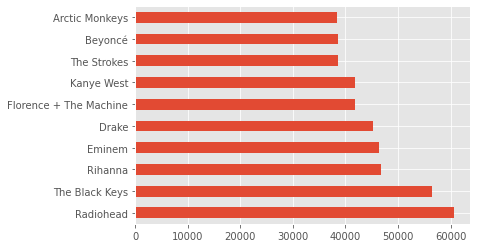

In [ ]:
# Top artists:
data['artist_name'].value_counts()[:10].plot(kind = 'barh');

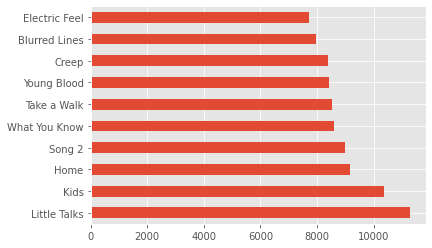

In [ ]:
# Top tracks
data['track_name'].value_counts()[:10].plot(kind = 'barh');

In [ ]:
#посмотреть данные по конкретному пользователю c идентификатором
user_data = data.groupby('user_id').get_group('6879b04def4c52a0d41e07b4f11136d6')
user_data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,user_id,playlistname
205,R&B,Usher,You Make Me Wanna...,47TqCCnEliDp8NRDyIQoQq,69,0.036,0.761,219120,0.639,0.000,F,0.095,-7.577,Minor,0.054,164.088,4/4,0.922,6879b04def4c52a0d41e07b4f11136d6,Songs of 1997
531,Dance,Usher,You Make Me Wanna...,47TqCCnEliDp8NRDyIQoQq,69,0.036,0.761,219120,0.639,0.000,F,0.095,-7.577,Minor,0.054,164.088,4/4,0.922,6879b04def4c52a0d41e07b4f11136d6,Songs of 1997
857,Hip-Hop,Usher,You Make Me Wanna...,47TqCCnEliDp8NRDyIQoQq,69,0.036,0.761,219120,0.639,0.000,F,0.095,-7.577,Minor,0.054,164.088,4/4,0.922,6879b04def4c52a0d41e07b4f11136d6,Songs of 1997
1183,Pop,Usher,You Make Me Wanna...,47TqCCnEliDp8NRDyIQoQq,69,0.036,0.761,219120,0.639,0.000,F,0.095,-7.577,Minor,0.054,164.088,4/4,0.922,6879b04def4c52a0d41e07b4f11136d6,Songs of 1997
1509,Rap,Usher,You Make Me Wanna...,47TqCCnEliDp8NRDyIQoQq,69,0.036,0.761,219120,0.639,0.000,F,0.095,-7.577,Minor,0.054,164.088,4/4,0.922,6879b04def4c52a0d41e07b4f11136d6,Songs of 1997


## Кластеризация K-Means

In [ ]:
#отбираем столбцы с звуковыми характеристиками песен
audio_features_data = data[['acousticness', 'valence','danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]

# выделяем 10 кластеров
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(audio_features_data)

# добавляем колонку с кластером к оригинальному датасету
audio_features_data['cluster'] = kmeans.labels_
data['cluster'] = kmeans.labels_

In [ ]:
def recommend_track(track_name, number_of_tracks=10):
    # выделяем характеристики трека, заданного пользователем
    input_track_features = data.loc[data['track_name'] == track_name, ['acousticness', 'valence','danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']].values
    
    # предсказываем кластер 
    input_track_cluster = kmeans.predict(input_track_features)[0]
    
    # рекомендуем треки из кластера
    recommendations = data[data['cluster'] == input_track_cluster].sample(number_of_tracks)[['track_name','artist_name']].values
    recommendations = pd.DataFrame(recommendations, columns=['Track name','Artist name'])
    recommendations = recommendations.drop_duplicates()

    return recommendations.head(number_of_tracks)

In [ ]:
recommend_track('Quand je monte chez toi')

,Track name,Artist name
0,Undead,Hollywood Undead
1,Two Weeks,Grizzly Bear
2,Hope With the Jet Set,Dead Kennedys
3,Fly Away,Lenny Kravitz
4,Baltimore,Nina Simone
5,Disparate Youth,Santigold
6,No Rain,Blind Melon
7,Somebody's Heartbreak,Hunter Hayes
8,Pressure,Paramore
9,You Won't Find This,Carrie Underwood


## Baseline Top Popular - как наибольшее число добавлений песни в плейлист по всем пользователям

In [ ]:
#срез из небольшого количества данных для тестирования алгоритма
df = data[:1000]

In [ ]:
#количество уникальных пользователей в срезе
len(df.user_id.unique())

322

In [ ]:
#количество уникальных треков в срезе
len(df.track_name.unique())

7

In [ ]:
def dict_from_data(data):
  
  data = data.drop(labels = ['genre', 'artist_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence',
       'playlistname'], axis = 1)
  d = {}
  for i in data['user_id'].unique():
    d[i] = {data['track_name'][j]: 1 for j in data[data['user_id']==i].index}

  return d

def get_pop_songs(d):
    songs_rating = {}
    for user, songs in d.items():
        for song, _ in songs.items():
            songs_rating.setdefault(song, 0) #поставили каждой песне частоту встречаемости 0 
            songs_rating[song] += 1 #если песня встречается больше одного раза увеличиваем счетчик
    songs_rating = dict(sorted(songs_rating.items(), key=lambda x: x[1], reverse=True)) #отсортированный словарь по убыванию рейтинга (частоты встречаемости) песен
    return songs_rating


def top_pop_recommender(d, user):
    recoms = get_pop_songs(d)
    recoms = {k: v for k, v in recoms.items() if k not in d[user]}
    return recoms

In [ ]:
#данные в формате словаря
d = dict_from_data(df)

In [ ]:
#самые популярные песни и кол-во их добавлений в плейлисты
get_pop_songs(d)

{'You Make Me Wanna...': 280,
 'Be Without You - Kendu Mix': 35,
 'This Is Gonna Be Good': 10,
 'Quand je monte chez toi': 2,
 'Dragon Ball GT': 1,
 'Takhti Par Takhti': 1,
 'The Pros Go To College': 1}

In [ ]:
# проверка работы алгоритма, сравнение результатов с таблицей из EDA

In [ ]:
# количество 'лайков' у каждого трека
likes_counts = df.groupby('track_name')['user_id'].nunique()

likes_counts_table = pd.DataFrame({'Track name': likes_counts.index, 
                                      'Number of Likes': likes_counts.values})
likes_counts_table = likes_counts_table.sort_values('Number of Likes', ascending=False)

likes_counts_table.head()

,Track name,Number of Likes
6,You Make Me Wanna...,280
0,Be Without You - Kendu Mix,35
5,This Is Gonna Be Good,10
2,Quand je monte chez toi,2
1,Dragon Ball GT,1


In [ ]:
#рекомендация для конкретного user_id 
top_pop_recommender(d, 'e897138cc060faf75a4a3d56c6ce2af1')

{'You Make Me Wanna...': 280,
 'Be Without You - Kendu Mix': 35,
 'This Is Gonna Be Good': 10,
 'Dragon Ball GT': 1,
 'Takhti Par Takhti': 1,
 'The Pros Go To College': 1}

## Content (Item) Based Cosine Similarity

In [ ]:
df = data.sample(100000)
df.reset_index(drop= True , inplace= True )

In [ ]:
df.drop_duplicates(subset=['track_name'], keep='first', inplace=True)

In [ ]:
#кодируем категориальные столбцы key, mode, time_signature
list_of_keys = df['key'].unique()
for i in range(len(list_of_keys)):
  df.loc[df.key == list_of_keys[i], 'key'] = i

df.loc[df['mode']== 'Major', 'mode'] = 1
df.loc[df['mode']== 'Minor', 'mode'] = 0

list_of_time_signatures = df['time_signature'].unique()
for i in range(len(list_of_time_signatures)):
  df.loc[df['time_signature'] == list_of_time_signatures[i], 'time_signature'] = i

In [ ]:
feature_cols=['acousticness', 'danceability', 'duration_ms', 'energy',
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence',]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_df =scaler.fit_transform(df[feature_cols])

print(normalized_df[:2])

[[4.32430283e-04 4.23655914e-01 3.52634181e-02 9.85982296e-01
  5.43259557e-05 0.00000000e+00 2.86951207e-01 8.98197729e-01
  1.00000000e+00 4.43381180e-02 7.02562640e-01 0.00000000e+00
  8.16986855e-01]
 [5.58232355e-01 4.12903226e-01 4.90180263e-02 2.12004762e-01
  5.55331992e-06 9.09090909e-02 4.43108893e-02 7.05115116e-01
  1.00000000e+00 6.59223817e-03 1.66641553e-01 0.00000000e+00
  1.25379171e-01]]


In [ ]:
indices = pd.Series(df.index, index=df['track_name']).drop_duplicates()

cosine = cosine_similarity(normalized_df)

In [ ]:
def generate_recommendation(track_name, model_type=cosine):
    """
    Purpose: Function for song recommendations 
    Inputs: song title and type of similarity model
    Output: Pandas series of recommended songs
    """
    
    idx=indices[track_name]

    sim_scores=list(enumerate(model_type[idx]))

    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)

    sim_scores = sim_scores[1:11]

    songs_indices = [i[0] for i in sim_scores]
  
    return df['track_name'].iloc[songs_indices]

In [ ]:
generate_recommendation('Tell Them Told You So', cosine)

99398    Showbiz? Science? Who Cares?
16893              Personality Crisis
1942                          Working
10537                 Railroad of Sin
399                      Mr. November
5423                        Australia
48633                      Olympia WA
64379           The General's Boombox
18925    Mersey Paradise - Remastered
53565                  This Afternoon
Name: track_name, dtype: object

## User-similarity

In [ ]:
df = data[:1000]

In [ ]:
df.playlistname = 1

пользователь одну и ту же песню добавляет в разные плейлисты, можно учитывать это как взвешенный рейтинг

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    df
    .groupby(['user_id', 'track_name']).playlistname.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['user_id', 'track_name'])
)
        
df = interactions_full_df.reset_index()
df.sample(5)

,user_id,track_name,playlistname
236,bf10a7712521cb03838b648e11a13ac2,Be Without You - Kendu Mix,2.585
182,95e58219ed964f79ca4eb2069aa1ee25,You Make Me Wanna...,2.000
74,3f0de935758bb29145611c83acc2786b,You Make Me Wanna...,1.585
121,62dc432e726e3723e30bda229f57366f,You Make Me Wanna...,1.585
114,5978d1bacdd18ee9d9e9a5b2dd4f42e7,You Make Me Wanna...,1.585


In [ ]:
d = {}
for i in df['user_id'].unique():
    d[i] = {df['track_name'][j]: df['playlistname'][j] for j in df[df['user_id']==i].index}

In [ ]:
def sim_distance(d, person1, person2):
    sum_of_squares = sum([(d[person1][item] - d[person2][item])**2
                         for item in d[person1] if item in d[person2]])
    return 1/(1 + np.sqrt(sum_of_squares))

In [ ]:
#схожесть двух пользователей
sim_distance(d,'3d0f759337e6aa576c75ecd3fbf14968','de05035bb2bba86bd702c3d54fc97e91')

0.7066950526114237

Сортировка пользователей на основе схожести

In [ ]:
def sort_users(d, person, n=5, similarity=sim_distance):
    scores = [(other, round(similarity(d, person, other),2)) for other in d if other != person]
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:n]

In [ ]:
sort_users(d,'3d0f759337e6aa576c75ecd3fbf14968', n=5)

[('00139e9cb50fb309549e1561b476226d', 1.0),
 ('014e695cc6df96011b90a5beb3206012', 1.0),
 ('01f9ad79c28415ac443eb7171e960381', 1.0),
 ('022c5c5e265cccedfeabae8299025c01', 1.0),
 ('030f98e11417305fab4c4e0d26274c63', 1.0)]

Рекомендации для схожих пользователей

In [ ]:
def get_recoms_by_users(prefs, person, similarity=sim_distance):
    totals = {}
    sim_sums = {}
    for other in prefs:
        if other == person:
            continue
        sim = similarity(prefs, person, other)
        if sim <= 0:
            continue
        for item in prefs[other]:
            if item not in prefs[person] or prefs[person][item] == 0:
                totals.setdefault(item, 0)
                totals[item] += prefs[other][item]*sim
                sim_sums.setdefault(item, 0)
                sim_sums[item] += sim

    rankings = [(item, round(total/sim_sums[item], 2)) for item, total in totals.items()]
    rankings = sorted(rankings, key=lambda x: x[1], reverse=True)
    
    return rankings

In [ ]:
get_recoms_by_users(d, '3d0f759337e6aa576c75ecd3fbf14968', sim_distance)

[('Be Without You - Kendu Mix', 2.66),
 ('The Pros Go To College', 1.0),
 ('This Is Gonna Be Good', 1.0),
 ('Dragon Ball GT', 1.0),
 ('Takhti Par Takhti', 1.0),
 ('Quand je monte chez toi', 1.0)]

## Коллаборативная фильтрация (memory based)

In [ ]:
#срез из небольшого количества данных для тестирования алгоритма
df = data[:200000]

In [ ]:
#количество уникальных пользователей в срезе
len(df.user_id.unique())

8596

In [ ]:
#количество уникальных треков в срезе
len(df.track_name.unique())

363

In [ ]:
df.drop(labels = ['genre', 'artist_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'], axis = 1, inplace = True)

In [ ]:
df.playlistname = 1

In [ ]:
#решение проблемы холодного старта, пользователи с 5 и более треками в плейлисте
users_interactions_count_df = (
    df
    .groupby(['user_id', 'track_name'])
    .first()
    .reset_index()
    .groupby('user_id').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['user_id']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 8596
# users with at least 5 interactions: 3013


<AxesSubplot:>

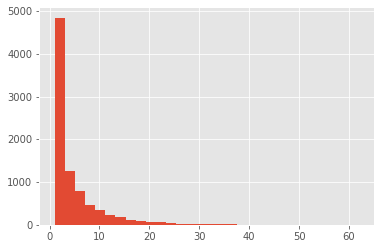

In [ ]:
users_interactions_count_df.hist(bins=30)

In [ ]:
interactions_from_selected_users_df = df.loc[np.in1d(df.user_id,
            users_with_enough_interactions_df)]

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [ ]:
print('# shape of dataset before:', df.shape)
print('# shape of dataset after:', interactions_from_selected_users_df.shape)

# shape of dataset before: (200000, 3)
# shape of dataset after: (149316, 3)


пользователь одну и ту же песню добавляет в разные плейлисты, можно учитывать это как взвешенный рейтинг 

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['user_id', 'track_name']).playlistname.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['user_id', 'track_name'])
)

        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(20)

,user_id,track_name,playlistname
0,001c4e5b73eca68ee9756bb0c7d2f855,Beneath Your Beautiful,2.322
1,001c4e5b73eca68ee9756bb0c7d2f855,Californication,2.000
2,001c4e5b73eca68ee9756bb0c7d2f855,Iris,2.322
3,001c4e5b73eca68ee9756bb0c7d2f855,Losing My Religion,2.322
4,001c4e5b73eca68ee9756bb0c7d2f855,Numb,2.000
5,001c4e5b73eca68ee9756bb0c7d2f855,Stacy's Mom,2.322
6,001c4e5b73eca68ee9756bb0c7d2f855,The Anthem,2.000
7,00287ecf491882a40ff34b0fd75a5b16,All Star,2.322
8,00287ecf491882a40ff34b0fd75a5b16,Black Widow,2.585
9,00287ecf491882a40ff34b0fd75a5b16,Bring Me To Life,1.585


In [ ]:
interactions_full_df.playlistname.unique()

array([2.32192809, 2.        , 2.5849625 , 1.5849625 , 3.45943162,
       2.80735492, 3.        , 3.70043972, 1.        , 3.169925  ,
       4.        , 3.32192809, 5.42626475, 4.24792751, 6.06608919,
       4.857981  , 4.39231742, 4.08746284, 4.70043972, 4.64385619,
       3.9068906 , 5.357552  , 5.12928302, 5.169925  , 4.45943162,
       5.20945337, 4.95419631, 5.64385619, 3.80735492, 5.04439412,
       5.52356196, 4.7548875 , 4.32192809, 5.61470984, 4.169925  ])

In [ ]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['user_id'], 
                                   test_size=0.25,
                                   random_state=42)

In [ ]:
print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 23740
# interactions on Test set: 7914


In [ ]:
interactions = (
    interactions_train_df
    .groupby('user_id')['track_name'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'track_name': 'true_train'})
    .set_index('user_id')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('user_id')['track_name'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
user_id,,
001c4e5b73eca68ee9756bb0c7d2f855,"[The Anthem, Californication, Losing My Religi...","[Numb, Iris]"
00287ecf491882a40ff34b0fd75a5b16,"[All Star, Stacy's Mom, My Own Worst Enemy, Ho...","[Bring Me To Life, Dancing in the Moonlight - ..."
00526df8fabfb8c8605f180ed1880754,"[You And Me, Safe And Sound, Black Widow, It G...","[Duality, Thinkin Bout You]"
0098b965803a4c10723f8e216f9e0904,"[Killing In The Name, I Still Miss Someone, Ma...",[Cruel To Be Kind]
009d96adf819aeed0bcff4448cad7a9a,"[Smells Like Teen Spirit, Tongue Tied, Come As...","[Thinkin Bout You, Creep]"


In [ ]:
interactions.shape

(3013, 2)

Матрица "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [ ]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='playlistname',
    index='user_id',
    columns='track_name').fillna(0)

In [ ]:
ratings

track_name,100 Miles,2AM.,500 Miles Away from Home,A Little Bit Of Everything,Ain't Back Yet,Ain't No God In Mexico,Alive,All I Do Is Win,All Star,All Summer Long,...,Wildfire,Would?,Write My Number On Your Hand,Wus Good / Curious,Y'all Come Back Saloon,You And Me,You Can't Take the Honky Tonk out of the Girl,You Make Me Wanna...,You'll Never Leave Harlan Alive,"You're Gonna Go Far, Kid"
user_id,,,,,,,,,,,,,,,,,,,,,
001c4e5b73eca68ee9756bb0c7d2f855,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
00287ecf491882a40ff34b0fd75a5b16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.322,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
00526df8fabfb8c8605f180ed1880754,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,3.700,0.000,0.000,0.000,0.000
0098b965803a4c10723f8e216f9e0904,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
009d96adf819aeed0bcff4448cad7a9a,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff6a160f76014ae59888eab018f03375,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ff83b4f72197d1c04338887bbebb9ce1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ffe11226cdea81a2db9262c0ec7f5d71,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
ratings_m = ratings.values

In [ ]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue

        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

  0%|          | 0/3012 [00:00<?, ?it/s]

In [ ]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):

    users_sim = similarity_users[i] > 0

    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

  0%|          | 0/3013 [00:00<?, ?it/s]

In [ ]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [ ]:
calc_precision('prediction_user_based')

0.25394177968339043

## SVD

In [ ]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='playlistname',
    index='user_id',
    columns='track_name').fillna(0)

In [ ]:
ratings = ratings[:3000]

In [ ]:
interactions = interactions[:3000]

In [ ]:
top_k = 10

In [ ]:
U, sigma, V = svd(ratings)

print(ratings.shape, U.shape, sigma.shape, V.shape)

(3000, 6121) (3000, 3000) (3000,) (6121, 6121)


In [ ]:
Sigma = np.zeros((3000, 6121))
Sigma[:3000, :3000] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))

1.0522944307934705e-23


In [ ]:
K = 100

sigma[K:] = 0
Sigma = np.zeros((3000, 6121))
Sigma[:3000, :3000] = np.diag(sigma)

In [ ]:
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

322764.00047817285
582018.7169313619


In [ ]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_svd'] = predictions

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
calc_precision('prediction_svd')

0.20152064334359837

## Факторизационная машина

In [ ]:
pip install git+https://github.com/coreylynch/pyFM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-bw7ohoi5
  Running command git clone --filter=blob:none --quiet https://github.com/coreylynch/pyFM /tmp/pip-req-build-bw7ohoi5
  Resolved https://github.com/coreylynch/pyFM to commit 0696c980993889a9429e4ab0b6c7dc8be6dac4de
  Preparing metadata (setup.py) ... done


In [ ]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

In [ ]:
#срез из небольшого количества данных для тестирования алгоритма
df = data[:20000]

df.drop(labels = ['genre', 'artist_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'], axis = 1, inplace = True)

df.playlistname = 1

In [ ]:
#решение проблемы холодного старта, пользователи с 5 и более треками в плейлисте
users_interactions_count_df = (
    df
    .groupby(['user_id', 'track_name'])
    .first()
    .reset_index()
    .groupby('user_id').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['user_id']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 2553
# users with at least 5 interactions: 90


In [ ]:
interactions_from_selected_users_df = df.loc[np.in1d(df.user_id,
            users_with_enough_interactions_df)]

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['user_id', 'track_name']).playlistname.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['user_id', 'track_name'])
)

        
interactions_full_df = interactions_full_df.reset_index()

In [ ]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['user_id'], 
                                   test_size=0.25,
                                   random_state=42)

In [ ]:
interactions = (
    interactions_train_df
    .groupby('user_id')['track_name'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'track_name': 'true_train'})
    .set_index('user_id')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('user_id')['track_name'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
user_id,,
03c7ce52321ad165332359e2395980fd,"[Hate That I Love You, Ridin' Solo, Countdown,...","[Creep, SOS]"
0655391291dfd9602e49b6276c8697cb,"[Where the Party At, Paranoid (feat. B.o.B), C...",[Right Thurr]
09c64defd6aa59945ebfa31e506ce0c3,"[Move Ya Body, Paranoid (feat. B.o.B), SOS, Ri...","[You Make Me Wanna..., Where the Party At]"
10c5e83789fd968addb25e7fb7d23cf0,"[Habits (Stay High), Ridin' Solo, Pretty Girl ...",[You Make Me Wanna...]
1139ad83b57a1e1d7a3690a7ff77e1c4,"[Habits (Stay High), Pretty Girl Rock, Creep, ...",[You Make Me Wanna...]


In [ ]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='playlistname',
    index='user_id',
    columns='track_name').fillna(0)

In [ ]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['user_id'] = str(interactions_train_df.iloc[i].user_id)
    features['track_name'] = str(interactions_train_df.iloc[i].track_name)

    try:
        dop_features = df2.loc[features['track_name']]
        features['genre'] = str(dop_features.genre)
        features['artist_name'] = str(dop_features.artist_name)
        features['popularity'] = str(dop_features.popularity)
        features['acousticness'] = str(dop_features.acousticness)
        features['danceability'] = str(dop_features.danceability)
        features['energy'] = str(dop_features.energy)
        features['instrumentalness'] = str(dop_features.instrumentalness)
        features['liveness'] = str(dop_features.liveness)
        features['loudness'] = str(dop_features.loudness)
    except:
        features['genre'] = 'unknown'
        features['genre'] = 'unknown'
        features['genre'] = 'unknown'

    train_data.append(features)

  0%|          | 0/421 [00:00<?, ?it/s]

In [ ]:
from copy import deepcopy

test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['user_id'] = str(interactions.index[i])  
    for j in range(len(ratings.columns)):

        features['track_name'] = str(ratings.columns[j])
        
        try:
            dop_features = df2.loc[features['track_name']]
            features['genre'] = str(dop_features.genre)
            features['artist_name'] = str(dop_features.artist_name)
            features['popularity'] = str(dop_features.popularity)
            features['acousticness'] = str(dop_features.acousticness)
            features['danceability'] = str(dop_features.danceability)
            features['energy'] = str(dop_features.energy)
            features['instrumentalness'] = str(dop_features.instrumentalness)
            features['liveness'] = str(dop_features.liveness)
            features['loudness'] = str(dop_features.loudness)
        except:
            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'

        test_data.append(deepcopy(features))

  0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))
test_features = dv.transform(test_data)

In [ ]:
y_train = list(interactions_train_df.playlistname.values) + list(np.zeros(29790))

In [ ]:
fm = pylibfm.FM(num_factors=10, num_iter=30, task='regression')

fm.fit(train_features, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.00399
-- Epoch 2
Training MSE: 0.00192
-- Epoch 3
Training MSE: 0.00170
-- Epoch 4
Training MSE: 0.00159
-- Epoch 5
Training MSE: 0.00150
-- Epoch 6
Training MSE: 0.00143
-- Epoch 7
Training MSE: 0.00138
-- Epoch 8
Training MSE: 0.00136
-- Epoch 9
Training MSE: 0.00137
-- Epoch 10
Training MSE: 0.00138
-- Epoch 11
Training MSE: 0.00137
-- Epoch 12
Training MSE: 0.00134
-- Epoch 13
Training MSE: 0.00132
-- Epoch 14
Training MSE: 0.00135
-- Epoch 15
Training MSE: 0.00132
-- Epoch 16
Training MSE: 0.00131
-- Epoch 17
Training MSE: 0.00131
-- Epoch 18
Training MSE: 0.00128
-- Epoch 19
Training MSE: 0.00126
-- Epoch 20
Training MSE: 0.00124
-- Epoch 21
Training MSE: 0.00124
-- Epoch 22
Training MSE: 0.00120
-- Epoch 23
Training MSE: 0.00121
-- Epoch 24
Training MSE: 0.00120
-- Epoch 25
Training MSE: 0.00117
-- Epoch 26
Training MSE: 0.00116
-- Epoch 27
Training MSE: 0.00115
-- Epoch 28
Tra

In [ ]:
test_features = dv.transform(test_data)

y_predict = fm.predict(test_features)

new_ratings = y_predict

In [ ]:
top_k=10

In [ ]:
predictions = []

for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(
        user_prediction[~np.in1d(user_prediction,
                                 interactions.loc[person, 'true_train'])][:top_k])
    
interactions['fm_prediction'] = predictions

In [ ]:
calc_precision('fm_prediction')

0.027752801365994777